# Veri - Software Developer Intern Task

### Author: Aleks Hiidenhovi

## Part 1: glucose data analysis
Before the task I was provided with four datasets: Two of the datasets contained measurements of glucose levels, every 15 minutes after a meal. The other two datasets contained scoring for the previous datasets. One of the glucose datasets contained 95 real user meals and 5 artificially generated meals while the other contained 95 artificial meals and 5 real meals. My task was to analyze, which one was which of the two datasets.

My main idea was to plot the datapoints in a plot and detect any patterns from the visualization. I also tried visualizing means and variances but they didn't seem to convey any meaningful information. Despite that, just plotting the data in a plot gave pretty solid evidence which one of the datasets was the real one.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Helper functions
def load_csv_into_dataframe(filename):
    return pd.read_csv(filename, sep=",", header=None)

def write_array_to_csv(array, filename):
    np.savetxt(filename, np.asarray(array), delimiter=",")

In [2]:
# Read the glucose csv-files
glucose_1 = pd.read_csv("glucose_data_1.csv", sep=",", header=None).T
glucose_2 = pd.read_csv("glucose_data_2.csv", sep=",", header=None).T

print(glucose_1.head())

         0         1         2         3         4         5         6   \
0  4.967649  5.574302  5.582249  5.270121  4.903771  5.954293  5.653215   
1  5.391409  5.974211  5.845180  6.609339  5.534948  5.997630  7.197494   
2  5.820523  5.429996  6.168633  6.137458  5.836622  6.813138  7.767409   
3  6.715383  5.839461  5.932418  6.908443  5.706379  7.175626  7.886842   
4  6.140176  5.123717  4.609703  7.415620  5.615342  6.215104  7.441082   

         7         8         9   ...        90        91        92        93  \
0  5.214131  5.299082  6.250912  ...  5.398320  5.353062  5.297848  4.812392   
1  5.917379  5.456986  6.361638  ...  5.261313  5.904335  5.420377  4.931191   
2  6.720396  5.817951  6.924125  ...  5.477077  6.348664  5.344216  4.697721   
3  7.264703  6.635919  7.396975  ...  5.612030  5.299615  4.953183  6.006254   
4  6.730027  6.145772  6.904468  ...  4.874928  4.789598  4.953217  5.615328   

         94        95        96        97        98        99  
0  5

Plot the data to quickly see if there are any patterns in either dataset

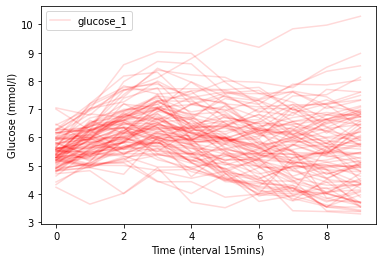

In [3]:
# Plotting the first dataset
plt.plot(glucose_1, "r", alpha=0.15)
plt.legend(["glucose_1"])
plt.xlabel("Time (interval 15mins)")
plt.ylabel("Glucose (mmol/l)")
plt.show()

In overall, the curves seem to act quite naturally. There's a slow increase for the first 30-60mins after the meal after which the glucose levels start to decrease slowly for most of the inputs. What looks a bit weird here that one of the measurements seems to keep growing throughout the whole timeframe. This could be one of the artificial data samples or alternatively someone with diabetes, for example. Let's check out the other data as well.


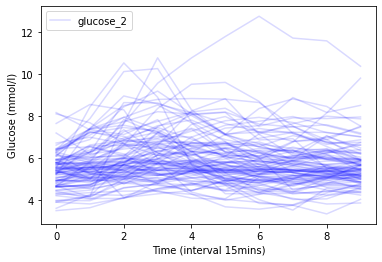

In [4]:
# Plotting the second dataset
plt.plot(glucose_2, "b", alpha=0.15)
plt.legend(["glucose_2"], loc="upper left")
plt.xlabel("Time (interval 15mins)")
plt.ylabel("Glucose (mmol/l)")
plt.show()

The second data seems to have steeper changes which seems unnatular compared to the first dataset. I would expect slower decreases in blood sugar instead of instantaneous spikes. Secondly, the data is lacking the slow increase trend during the first 30-60 minutes that the first dataset has. There are some spikes along the 45-minute mark but there isn't as clear a pattern as in the first dataset.


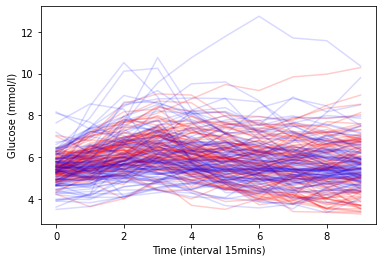

In [5]:
# Both at the same time
plt.plot(glucose_1, "r", alpha=0.2)
plt.plot(glucose_2, "b", alpha=0.15)
plt.xlabel("Time (interval 15mins)")
plt.ylabel("Glucose (mmol/l)")
plt.show()

Based on all the graphs, I'm pretty confident that the first dataset is the dataset with 95 real meals and the second one is the artificial dataset with only 5 reals meals. Main evidence being the slow increase followed with a slow decrease of glucose levels within the first 30-60 minutes in the first dataset and the pointy, quick changes of the second dataset.

## Part 2: meal scoring tool

My plan is to build a deep neural network that takes (m, 10)-dimensional array as input and outputs a single scoring number which can have integer values from 1-10.

The pre-step before building a neural network is to first have a human or an algorithm score meals. The neural network will be able to learn to predict future scores from the previous scores. Human scoring is preferred for training set labeling since this allows higher quality training data.

Building the model will be done in the following steps:
1. Data Preprocessing
2. Model Building and Hyperparameter Tuning
3. Predictions and Outputting the csv-file

In [6]:
# Import libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Global variables
random_state = 1 # for seeding purposes

### Step 1: Data Preprocessing

Firstly I want to create the training and test sets. Optimally I would have a cross-validation set as well but given the small amount of data I opted to only use a test set to validate my model. Therefore the test set acts like a dev set would in a normal situation.

In [7]:
# Read the original files to pandas dataframes
glucose = load_csv_into_dataframe("glucose_data.csv")
scores = load_csv_into_dataframe("scores.csv").astype(int).to_numpy().reshape(-1)

print(f"Glucose shape: {glucose.shape}")
print(f"Scores shape: {scores.shape}")

Glucose shape: (2000, 10)
Scores shape: (2000,)


### Step 2: Model Building and Hyperparameter Tuning
For hyperparameter tuning I decided to take a step-by-step approach. 

Firstly, I wanted to optimize learning potential of the algorithm. I tuned the amount of layers, hidden units and regularization parameter alpha to test networks with different complexities and to see which networks performed the best.

Secondly I wanted to optimize the learning speed of the algorithm and I chose to tune learning rate and batch size.

I decided to use two measures to test the accuracy of my model: percentage of scores that are off by 1 at most and mean absolute difference. The model performance could be decent, even if the plain accuracy percentage was low. This could happen if the model often gave scores off by just 1. This is why I opted to count in predictions that are off by  maximum 1 since this can happen quite often, but isn't detrimental for the model performance. Out of the two measures I consider MAD-score to be the better one since it averages out well over larger sample sizes.

#### Step 2.1: Creating the training and test sets

In [8]:
# Create the training-test split with 80% training size 
X_train, X_test, y_train, y_test = train_test_split(glucose, scores, test_size=0.2, random_state=random_state)

#### Step 2.2: Accuracy and model functions

In [9]:
# Calculate the percentage of accurate predictions
def prediction_accuracy(actual_scores, predictions):
    assert actual_scores.size == predictions.size, "Incorrect array sizes!"
    return np.sum(np.abs(actual_scores - predictions) <= 1) / actual_scores.size
    
    
# Calculate the mean absolute difference of the predictions
def mean_absolute_diff(actual_scores, predictions):
    score_size = actual_scores.size
    pred_size = predictions.size
    assert score_size == pred_size, "Incorrect array sizes!"
    
    return 1 / score_size * np.sum(np.abs(actual_scores - predictions))


# Train the model, return model metrics and model
def train(X_train, y_train, X_test, y_test, hidden_layer_sizes=(1000,), activation="relu", 
          solver="adam", alpha="0.01", batch_size='auto', learning_rate_init=0.01, 
          learning_rate="invscaling", max_iter=1000, random_state=random_state, classes=np.arange(1, 11)):
    
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
                       solver=solver, alpha=alpha, batch_size=batch_size,
                       learning_rate_init=learning_rate_init, learning_rate=learning_rate,
                       max_iter=max_iter, random_state=random_state)
    
    clf.fit(X_train, y_train)
    softmax_outputs = clf.predict_proba(X_test)
    y_pred = np.argmax(softmax_outputs, axis=1) + 1
    
    accuracy = prediction_accuracy(y_test, y_pred)
    mad_score = mean_absolute_diff(y_test, y_pred)
    
    return accuracy, mad_score, clf


# Plots the accuracy and MAD-score of the model with textual summary
def plot_metrics(accuracy_scores, mad_scores):
    max_acc_idx = np.argmax(accuracy_scores)
    min_mad_idx = np.argmin(mad_scores)

    acc_line, = plt.plot(accuracy_scores, "r")
    mad_line, = plt.plot(mad_scores, "b")
    plt.legend([acc_line, mad_line], ["Accuracy", "MAD-score"], loc="center right")
    plt.vlines(max_acc_idx, 0, 1, color="r")
    plt.vlines(min_mad_idx, 0, 1, color="b")
    plt.show()

    print(f"Maximum accuracy on index {max_acc_idx} (higher is better): {np.max(accuracy_scores)}")
    print(f"Minimum MAD-score on index {min_mad_idx} (lower is better): {np.min(mad_scores)}")
    print("\n")
    
    print(f"Accuracy scores: {accuracy_scores}")
    print(f"MAD scores: {mad_scores}")
    print("\n")

#### 2.3 Regularization, hidden layers and hidden units
I first trained 24 neural networks with regularization parameter alphas (0.0001, 0.001, 0.01, 0.1) and 1-3 layer networks with hidden units 200 and 1000.

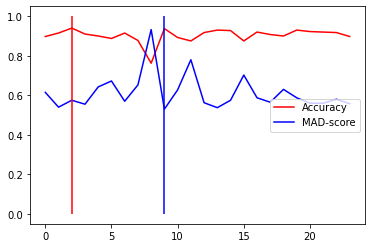

Maximum accuracy on index 2 (higher is better): 0.94
Minimum MAD-score on index 9 (lower is better): 0.53


Accuracy scores: [0.8975 0.915  0.94   0.91   0.9    0.8875 0.915  0.8775 0.7625 0.9375
 0.8925 0.875  0.9175 0.93   0.9275 0.875  0.92   0.9075 0.9    0.93
 0.9225 0.92   0.9175 0.8975]
MAD scores: [0.615  0.54   0.575  0.555  0.6425 0.6725 0.57   0.6525 0.9325 0.53
 0.6275 0.78   0.5625 0.5375 0.575  0.7025 0.5875 0.565  0.63   0.5875
 0.56   0.56   0.58   0.5575]


Let's choose model with the lowest MAD-score: 9
alpha = 0.001
hidden_layers = (1000,)


In [10]:
accuracy_scores = np.array([])
mad_scores = np.array([])
alphas = [0.0001, 0.001, 0.01, 0.1]
hidden_layers = [(200,), (200, 200), (200, 200, 200), (1000,), (1000, 1000), (1000, 1000, 1000)]

for alpha in alphas:
    for hl in hidden_layers:
        accuracy, mad_score, clf = train(X_train, y_train, X_test, y_test, hidden_layer_sizes=hl, alpha=alpha)
        accuracy_scores = np.concatenate([accuracy_scores, np.array([accuracy])])
        mad_scores = np.concatenate([mad_scores, np.array([mad_score])])

plot_metrics(accuracy_scores, mad_scores)

model_idx = np.argmin(mad_scores)
final_alpha = alphas[model_idx // len(hidden_layers)]
final_hidden_layers = hidden_layers[model_idx % len(hidden_layers)]

print(f"Let's choose model with the lowest MAD-score: {model_idx}")
print(f"alpha = {final_alpha}")
print(f"hidden_layers = {final_hidden_layers}")

#### Step 2.4 Learning rate and minibatch size
For the next step I stick with the combo that gave the lowest MAD-score in previous test. Now I train 12 more networks with learning rates (0.0001, 0.001, 0.01) and batch sizes (100, 200, 500, 1000)

/opt/anaconda3/envs/veri/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/veri/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/veri/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/veri/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


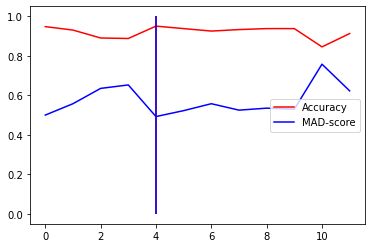

Maximum accuracy on index 4 (higher is better): 0.95
Minimum MAD-score on index 4 (lower is better): 0.4925


Accuracy scores: [0.9475 0.93   0.89   0.8875 0.95   0.9375 0.925  0.9325 0.9375 0.9375
 0.845  0.9125]
MAD scores: [0.5    0.5575 0.635  0.6525 0.4925 0.5225 0.5575 0.525  0.535  0.53
 0.7575 0.6225]


Let's choose model with the lowest MAD-score: 4
learning_rate = 0.001
batch_size = 100


In [11]:
accuracy_scores = np.array([])
mad_scores = np.array([])
models = []
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [100, 200, 500, 1000]

for lr in learning_rates:
    for batch_size in batch_sizes:
        accuracy, mad_score, clf = train(X_train, y_train, X_test, y_test, hidden_layer_sizes=final_hidden_layers,
                                    alpha=final_alpha, batch_size=batch_size, learning_rate_init=lr)
        accuracy_scores = np.concatenate([accuracy_scores, np.array([accuracy])])
        mad_scores = np.concatenate([mad_scores, np.array([mad_score])])
        models.append(clf)

plot_metrics(accuracy_scores, mad_scores)

model_idx = np.argmin(mad_scores)
final_lr = learning_rates[model_idx // len(batch_sizes)]
final_batch_size = batch_sizes[model_idx % len(batch_sizes)]
final_model = models[model_idx]

print(f"Let's choose model with the lowest MAD-score: {model_idx}")
print(f"learning_rate = {final_lr}")
print(f"batch_size = {final_batch_size}")

### Step 3: Predictions and Outputting the csv-file
Lastly I predicted the labels with the final model and the final scores for the model. Then I export the results to a csv-file.

In [24]:
softmax_outputs = final_model.predict_proba(X_test)
final_predictions = np.argmax(softmax_outputs, axis=1) + 1

final_accuracy = prediction_accuracy(y_test, final_predictions)
final_mad_score = mean_absolute_diff(y_test, final_predictions)

print("-----Model performance-----")
print(f"One-off accuracy: {final_accuracy}")
print(f"MAD-score: {final_mad_score}")

print("\n")

print("-----Scores-----")
sample_size = 48
print(f"First {sample_size} actual scores:\n {y_test[:sample_size]}")
print(f"First {sample_size} predicted scores:\n {final_predictions[:sample_size]}")

-----Model performance-----
One-off accuracy: 0.95
MAD-score: 0.4925


-----Scores-----
First 48 actual scores:
 [ 8  5  5  5  8  7 10 10  6 10  6  8 10  7 10  7  4  7 10  7  8  7  9 10
  8  9  8  9  7  9  3  7  8  9  8 10  7  7  9  7  8  7 10  7  8 10  6  9]
First 48 predicted scores:
 [ 7  6  7  6  7  9 10 10  5  9  6 10 10  7  9  7  4  6  9  7  9  7  9 10
  9  9 10 10  7  9  4  6  8  9  7 10  7  8  9  8  7  8 10  7  7 10  5  9]


In [14]:
write_array_to_csv(final_predictions, "final_predictions.csv")

### Conclusions
My model achieved 95% one-off accuracy and MAD-score of 0.4925 which I consider pretty good, given the amount of data and hyperparameter tuning.

Some ways I would try to improve the performance of the model if I spent more time on it:
1. Collect more, high quality data.
2. The best option ended up being a shallow network with 1 hidden layer. My first intuition is that the networks with multiple layers might have overfitted the data and that way performed worse. I would retest the deeper networks after collecting more data but also try shallower networks with more hidden units to see how they perform
3. Better accuracy measurements: I opted to use the one-off measure for this task. Ideally I would add a third measure that would measure the exact accuracy of the predictions. Then I would use all three measures together to make the decision, which model I would continue with in each step.

### Step 3: Accuracy Tests
I decided to use two measures to test the accuracy of my model: percentage of scores that are off by 1 at most and mean absolute difference. Out of the two measures I consider MAD-score to be the more practical one since it averages out better over large sample sizes. 

Plain accuracy percentage could be low even if the model performance is decent. This is why I opted to count in predictions that are off by 1 since this can happen quite often.

In [ ]:
# Calculate the percentage of accurate predictions
def prediction_accuracy(actual_scores, predictions):
    assert actual_scores.size == predictions.size, "Incorrect array sizes!"
    return np.sum(np.abs(actual_scores - predictions) <= 1) / actual_scores.size
    
# Calculate the mean absolute difference of the predictions
def mean_absolute_diff(actual_scores, predictions):
    score_size = actual_scores.size
    pred_size = predictions.size
    assert score_size == pred_size, "Incorrect array sizes!"
    
    return 1 / score_size * np.sum(np.abs(actual_scores - predictions))
    
print(f"Accurate predictions: {prediction_accuracy(y_test, y_pred)}")
print(f"MAD-score: {mean_absolute_diff(y_test, y_pred)}")

In [ ]:
alphas = [0.0001]
hidden_layers = [(200,), (200, 200), (200, 200, 200)]

In [ ]:
# Turn scores to one-hot vectors, i.e vector that has zeros on all 
# indices except the one with the score index.
# Example: Score 3 --> [0 0 1 0 0 0 0 0 0 0 0]
samples = scores.size
classes = int(scores.max())

one_hot_scores = np.zeros((samples, classes)).astype(int)
one_hot_scores[np.arange(samples), scores - 1] = 1

# Sanity check
print(f"First five scores: {scores[:5]}")
print(f"First five one-hot vectors:\n {one_hot_scores[:5]}")

In [ ]:
# Read the original files to pandas dataframes
glucose_1 = load_csv_into_dataframe("glucose_data_1.csv")
glucose_2 = load_csv_into_dataframe("glucose_data_2.csv")
scores_1 = load_csv_into_dataframe("scores_1.csv").astype(int)
scores_2 = load_csv_into_dataframe("scores_2.csv").astype(int)

# Concatenate the glucose and scores datasets respectively
glucose_all = df_concat(glucose_1, glucose_2)
scores_all = df_concat(scores_1, scores_2).reshape(-1)

print(f"Glucose_1 shape: {glucose_1.shape}")
print(f"Glucose_2 shape: {glucose_2.shape}")
print(f"Scores_1 shape: {scores_1.shape}")
print(f"Scores_2 shape: {scores_2.shape}")

print(f"Glucose_all shape: {glucose_all.shape}")
print(f"Scores_all shape: {scores_all.shape}")

In [ ]:
mask_1 = glucose_1.max(axis=0) > 9.5
anomaly_1 = glucose_1.loc[:, mask_1]
plt.plot(anomaly_1, "r")

mask_2 = glucose_2.max(axis=0) > 12
anomaly_2 = glucose_2.loc[:, mask_2]
plt.plot(anomaly_2, "b")

plt.show()

In [ ]:
std1 = glucose_1.std(axis=0)
std2 = glucose_2.std(axis=0)

line1, = plt.plot(std1, "r", alpha=0.5)
line2, = plt.plot(std2, "b", alpha=0.5)
plt.legend([line1, line2], ["glucose_1", "glucose_2"], loc="upper right")
plt.xlabel("Sample index")
plt.ylabel("Std")
plt.show()

In [ ]:
mean1 = glucose_1.mean(axis=0)
mean2 = glucose_2.mean(axis=0)

line1, = plt.plot(mean1, "r", alpha=0.5)
line2, = plt.plot(mean2, "b", alpha=0.5)
plt.legend([line1, line2], ["glucose_1", "glucose_2"])
plt.xlabel("Sample index")
plt.ylabel("Mean")
plt.show()

print(f"Std of the mean1: {mean1.std()}")
print(f"Std of the mean2: {mean2.std()}")

Second dataset seems to have bigger variations in the means and standard deviations of the samples. My hypothesis is that the real data will have less fluctuations with both statistics and therefore this supports the idea that the second dataset the artificial dataset.